# 第9章: RNN, CNN

## 80.ID番号への変換
問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ．

In [2]:
from itertools import islice
from collections import Counter, defaultdict
import nltk

train_path = '../chapter06/data_folder/train.txt'

word_list = []
with open(train_path,'r') as f:
    for l in f:
        title, category = l.split('\t')
        title = title.lower()
        words = nltk.word_tokenize(title)
        word_list.extend(words)

In [ ]:
print(len(word_list))
count = Counter(word_list)
vocab_size = len(count)
print(vocab_size)

In [ ]:
import pickle

def pickle_dump(obj, file):
    with open(file, mode='wb') as f:
        pickle.dump(obj, f)

word2id = defaultdict(int)
for i, (w, c) in enumerate(count.most_common(), 1):
    if c == 1:
        word2id[w] = 0
    else:
        word2id[w] = i
        
pickle_dump(word2id, './data/word2id.pickle')

In [ ]:
print(len(word2id))
print([l for l in islice(word2id.items(), 10)])

In [ ]:
# 前処理
from torch.utils.data import TensorDataset
from torch.nn.utils.rnn import pad_sequence

def title2vec(title):
    words = nltk.word_tokenize(title.lower())
    idseq = []
    for i, w in enumerate(words):
        if w in word2id:
            idseq.append(word2id[w])
        else:
            idseq.append(0)
    return torch.as_tensor(idseq)

def make_dataset_torch(process):
    path = f'../chapter06/data_folder/{process}.txt'
    category2id = {'b':0, 't':1, 'e':2, 'm':3}
    x, y = [], []
    
    with open(path,'r') as f:
        for l in f:
            title, category = l.strip().split('\t')
            idseq, label = title2vec(title), category2id[category]
            x.append(idseq)
            y.append(torch.tensor(label))

    x = pad_sequence(x, batch_first=True)
    y = torch.stack(y)
    print(x.shape)
    print(y.shape)
    torch.save(TensorDataset(x, y), f'./data/{process}.pt')

In [ ]:
import torch

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

word2id = pickle_load('./data/word2id.pickle')
vocab_size = len(word2id)

with open(train_path,'r') as f:
    for l in islice(f, 1):
        title = l.split('\t')[0]
        vec = title2vec(title)
        print(vec)
        print(vec.shape)

In [ ]:
# データセット作成
vocab_size = len(word2id)
print(vocab_size)
make_dataset_torch('train')
make_dataset_torch('test')

## 81.RNNによる予測
ID番号で表現された単語列x=(x1,x2,…,xT)がある．ただし，Tは単語列の長さ，xt∈ℝVは単語のID番号のone-hot表記である（Vは単語の総数である）．再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列xからカテゴリyを予測するモデルとして，次式を実装せよ．

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

vocab_size = len(word2id)
embeds_dim = 300
hidden_state_dim = 50
num_of_labels = 4

model = keras.Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embeds_dim))
model.add(layers.SimpleRNN(hidden_state_dim, activation='tanh', use_bias=True))
model.add(layers.Dense(num_of_labels, input_dim=50)) 
model.add(layers.Softmax(axis=-1))
model.summary()

In [ ]:
vocab_size = len(word2id)

with open(data_path,'r') as f:
    for l in islice(f, 1):
        title = l.split('\t')[0]
        print(title)
        vec = title2vec(title, vocab_size)
        print(vec.shape)
        print(vec)

In [ ]:
output = model.predict(vec)
print(output.shape)
output

## 82.確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

出力は1sentenceに対し(1, 4)のベクトル

In [4]:
# データセットのロード
import torch
from torch.utils.data import DataLoader
batch_size = 32

train_dataset = torch.load('./data/train.pt')
test_dataset = torch.load('./data/test.pt')
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# shapeを確認
for x, y in train_data_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 31])
torch.Size([32])


In [6]:
# モデル設定
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class MyRnn(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, padding_id):
        super(MyRnn, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_id)
        self.rnn = nn.RNN(embed_dim, hidden_dim, bias=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)
        
    def forward(self, x):
        batch_size = x.shape[0]
#         length = [x.shape[1]]
        length = [np.count_nonzero(idseq.detach().numpy() != 0) for idseq in x]
        hidden = torch.zeros(1, batch_size, self.hidden_dim)
        embeds = self.embedding(x)
        packed_input = pack_padded_sequence(embeds, length, batch_first=True, enforce_sorted=False)
        out, hidden = self.rnn(packed_input, hidden)
#         out, hidden = self.rnn(embeds, hidden)
        logit = self.fc(hidden)
        
        return logit, hidden

In [7]:
#評価用の関数
def test(model, data_loader):
#     with torch.no_grad:
    total_loss = 0
    y_true, y_pred = [], []

    for x, y in data_loader:
        out, hidden = model(x)
        loss = loss_func(out[0], y)

        total_loss += loss
        pred = out[0].argmax(-1)
        for p, t in zip(pred, y):
            y_true.append(t)
            y_pred.append(p)
    loss_ave = total_loss / x.shape[0]
    acc = accuracy_score(y_true, y_pred)
        
    return loss_ave, acc

In [8]:
# 学習
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import accuracy_score

max_epoch = 10
vocab_size = 15438
model = MyRnn(vocab_size, 300, 50, 4, padding_id=0)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()

losses, accs = [], []
test_losses, test_accs = [], []

for epoch in range(max_epoch):
    y_true, y_pred = [], []
    total_loss = 0
    
    for x, y in tqdm(train_data_loader):
        out, hidden = model(x)
        optimizer.zero_grad()
        loss = loss_func(out[0], y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        pred = out[0].argmax(-1)
        for p, t in zip(pred, y):
            y_true.append(t)
            y_pred.append(p)

    loss_ave = total_loss / x.shape[0]
    acc = accuracy_score(y_true, y_pred)
    losses.append(loss_ave)
    accs.append(acc)
    
    #評価
    test_loss, test_acc = test(model, test_data_loader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

100%|██████████| 334/334 [00:05<00:00, 59.69it/s]


In [ ]:
#lossの推移
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_palette('viridis') 
fig = plt.figure(figsize=(10, 5))

plt.xlabel('epoch')
plt.ylabel('loss')

plt.plot(range(max_epoch), losses, label='train')
plt.plot(range(max_epoch), test_losses, label='test')
plt.legend()

In [ ]:
#精度の推移
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_palette('viridis') 
fig = plt.figure(figsize=(10, 5))

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.plot(range(max_epoch), accs, label='train')
plt.plot(range(max_epoch), test_accs, label='test')

## 83.ミニバッチ化・GPU上での学習
問題82のコードを改変し，B事例ごとに損失・勾配を計算して学習を行えるようにせよ（Bの値は適当に選べ）．また，GPU上で学習を実行せよ．

In [ ]:
from IPython.display import Image, display_png
display_png(Image("./data/loss.png"))

In [ ]:
from IPython.display import Image, display_png
display_png(Image("./data/accuracy.png"))

### 84.単語ベクトルの導入
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル）で単語埋め込みemb(x)を初期化し，学習せよ．

In [ ]:
#単語ベクトルのフォーマット
from gensim.models import KeyedVectors
path = '../chapter07/data/GoogleNews-vectors-negative300.bin'
word_vectors = KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
weights = torch.FloatTensor(word_vectors.vectors)
torch.save(weights, 'data/weight.pt')

In [ ]:
# モデル設定
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class MyRnn(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, padding_id, weight):
        super(MyRnn, self).__init__()
        self.hidden_dim = hidden_dim
#         self.embedding = nn.Embedding(vocab_size, embed_dim, padding_id)
        self.embedding = nn.Embedding.from_pretrained(weight)
        self.rnn = nn.RNN(embed_dim, hidden_dim, bias=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)
        
    def forward(self, x):
        batch_size = x.shape[0]
#         length = [x.shape[1]]
        length = [np.count_nonzero(idseq.detach().numpy() != 0) for idseq in x]
        hidden = torch.zeros(1, batch_size, self.hidden_dim)
        embeds = self.embedding(x)
        packed_input = pack_padded_sequence(embeds, length, batch_first=True, enforce_sorted=False)
        out, hidden = self.rnn(packed_input, hidden)
#         out, hidden = self.rnn(embeds, hidden)
        logit = self.fc(hidden)
        
        return logit, hidden

In [ ]:
# 学習
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import accuracy_score

weights = torch.FloatTensor(word_vectors.vectors)

max_epoch = 10
vocab_size = 15438
model = MyRnn(vocab_size, 300, 50, 4, padding_id=0, weight=weights)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()

losses, accs = [], []
test_losses, test_accs = [], []

for epoch in range(max_epoch):
    y_true, y_pred = [], []
    total_loss = 0
    
    for x, y in tqdm(train_data_loader):
        out, hidden = model(x)
        optimizer.zero_grad()
        loss = loss_func(out[0], y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        pred = out[0].argmax(-1)
        for p, t in zip(pred, y):
            y_true.append(t)
            y_pred.append(p)

    loss_ave = total_loss / x.shape[0]
    acc = accuracy_score(y_true, y_pred)
    losses.append(loss_ave)
    accs.append(acc)
    
    #評価
    test_loss, test_acc = test(model, test_data_loader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

In [ ]:
#lossの推移
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_palette('viridis') 
fig = plt.figure(figsize=(10, 5))

plt.xlabel('epoch')
plt.ylabel('loss')

plt.plot(range(max_epoch), losses, label='train')
plt.plot(range(max_epoch), test_losses, label='test')
plt.legend()

In [ ]:
#精度の推移
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_palette('viridis') 
fig = plt.figure(figsize=(10, 5))

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.plot(range(max_epoch), accs, label='train')
plt.plot(range(max_epoch), test_accs, label='test')

### 85.双方向RNN・多層化
順方向と逆方向のRNNの両方を用いて入力テキストをエンコードし，モデルを学習せよ．

In [ ]:
# データセットのロード
import torch
from torch.utils.data import DataLoader
batch_size = 32

train_dataset = torch.load('./data/train.pt')
test_dataset = torch.load('./data/test.pt')
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#引数bidirectionalをtrueにすればいいだけではないか？
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class MyRnn(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, padding_id):
        super(MyRnn, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_id)
        self.rnn = nn.RNN(embed_dim, hidden_dim, bias=True, batch_first=True, 
                          bidirectional=True, num_layers=2)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)
        
    def forward(self, x):
        batch_size = x.shape[0]
#         length = [x.shape[1]]
        length = [np.count_nonzero(idseq.detach().numpy() != 0) for idseq in x]
        hidden = torch.zeros(4, batch_size, self.hidden_dim)
        embeds = self.embedding(x)
        packed_input = pack_padded_sequence(embeds, length, batch_first=True, enforce_sorted=False)
        out, hidden = self.rnn(packed_input, hidden)
#         out, hidden = self.rnn(embeds, hidden)
        logit = self.fc(hidden)
        
        return logit, hidden

In [ ]:
# 学習
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import accuracy_score

max_epoch = 10
vocab_size = 15438
model = MyRnn(vocab_size, 300, 50, 4, padding_id=0)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()

losses, accs = [], []
test_losses, test_accs = [], []

for epoch in range(max_epoch):
    y_true, y_pred = [], []
    total_loss = 0
    
    for x, y in tqdm(train_data_loader):
        out, hidden = model(x)
        optimizer.zero_grad()
        loss = loss_func(out[0], y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        pred = out[0].argmax(-1)
        for p, t in zip(pred, y):
            y_true.append(t)
            y_pred.append(p)

    loss_ave = total_loss / x.shape[0]
    acc = accuracy_score(y_true, y_pred)
    print('train: ', loss_ave)
    print('train: ', acc)
    losses.append(loss_ave)
    accs.append(acc)
    
    #評価
    test_loss, test_acc = test(model, test_data_loader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

In [ ]:
#lossの推移
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_palette('viridis') 
fig = plt.figure(figsize=(10, 5))

plt.xlabel('epoch')
plt.ylabel('loss')

plt.plot(range(max_epoch), losses, label='train')
plt.plot(range(max_epoch), test_losses, label='test')
plt.legend()

In [ ]:
#精度の推移
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_palette('viridis') 
fig = plt.figure(figsize=(10, 5))

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.plot(range(max_epoch), accs, label='train')
plt.plot(range(max_epoch), test_accs, label='test')

### 86.畳み込みニューラルネットワーク (CNN)
ID番号で表現された単語列x=(x1,x2,…,xT)がある．ただし，Tは単語列の長さ，xt∈ℝVは単語のID番号のone-hot表記である（Vは単語の総数である）．畳み込みニューラルネットワーク（CNN: Convolutional Neural Network）を用い，単語列xからカテゴリyを予測するモデルを実装せよ．

In [ ]:
# データセットのロード
import torch
from torch.utils.data import DataLoader
batch_size = 1

train_dataset = torch.load('./data/train.pt')
train_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# モデル設定
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class MyCnn(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, padding_id):
        super(MyCnn, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_id)
        self.conv = nn.Conv1d(embed_dim, hidden_dim, kernel_size=3, stride=1, bias=True, padding=1)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(hidden_dim, output_dim)
                
    def forward(self, x):
        x = self.embedding(x)
        # 行列のshapeを[バッチ数, 入力の長さ, 埋め込み次元数] -> [バッチ数, 埋め込み次元数, 入力の長さ]に変形
        x = x.transpose(-1, -2)
        # pad_packed_sequenceをしていない
        x = self.conv(x)
        x = self.relu(x)
        # 入力1つごとに、ベクトルの最大要素を取得
        x, _ = torch.max(x, dim=2)
        x = self.linear(x)
        
        return x

In [ ]:
from itertools import islice
vocab_size = 15438
model = MyCnn(vocab_size, 300, 50, 4, padding_id=0)

for x, y in train_data_loader:
    out = model(x)
    out = F.softmax(out)
    for o in out:
        print(o.argmax(-1))
        break
    break

### 87.確率的勾配降下法によるCNNの学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [ ]:
# データセットのロード
from torch.utils.data import DataLoader
batch_size = 32

train_dataset = torch.load('./data/train.pt')
test_dataset = torch.load('./data/test.pt')
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#評価用の関数
def test(model, data_loader):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        y_true, y_pred = [], []

        for x, y in data_loader:
            out = model(x)
            loss = loss_func(out, y)

            total_loss += loss
            pred = out.argmax(-1)
            for p, t in zip(pred, y):
                y_true.append(t)
                y_pred.append(p)
        loss_ave = total_loss / x.shape[0]
        acc = accuracy_score(y_true, y_pred)

        return loss_ave, acc

In [ ]:
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import accuracy_score

max_epoch = 10
vocab_size = 15438
model = MyCnn(vocab_size, 300, 50, 4, padding_id=0)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()

losses, accs = [], []
test_losses, test_accs = [], []

for epoch in range(max_epoch):
    model.train()
    y_true, y_pred = [], []
    total_loss = 0
    
    for x, y in tqdm(train_data_loader):
        out = model(x)
        optimizer.zero_grad()
        loss = loss_func(out, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        pred = out.argmax(-1)
        for p, t in zip(pred, y):
            y_true.append(t)
            y_pred.append(p)

    loss_ave = total_loss / x.shape[0]
    acc = accuracy_score(y_true, y_pred)
    losses.append(loss_ave)
    accs.append(acc)
    
    #評価
    test_loss, test_acc = test(model, test_data_loader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_graph(process, train_result, test_result):
    #lossの推移
    sns.set()
    sns.set_palette('viridis')
    fig = plt.figure(figsize=(10, 5))
    plt.xlabel('epoch')
    plt.ylabel(process)
    plt.plot(range(max_epoch), train_result, label='train')
    plt.plot(range(max_epoch), test_result, label='test')
    plt.legend()

In [ ]:
#lossの推移
draw_graph('loss', losses, test_losses)

In [ ]:
#精度の推移
draw_graph('accuracy', accs, test_accs)

### 88.パラメータチューニング
問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．

RNN層:4層  
batch size:64  
max epoch: 100  
max accucary:0.9832444070017785(test)

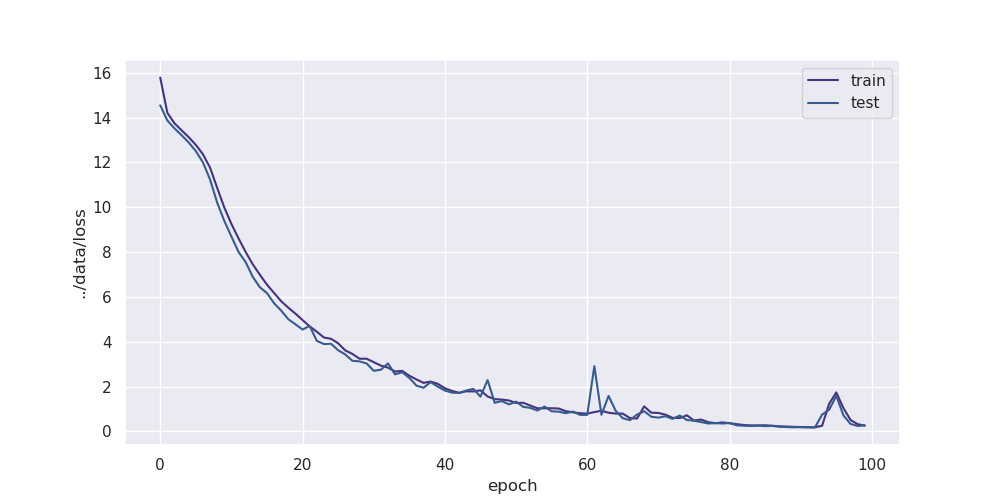

In [9]:
from IPython.display import Image, display_png
display_png(Image("./data/loss_q88.png"))

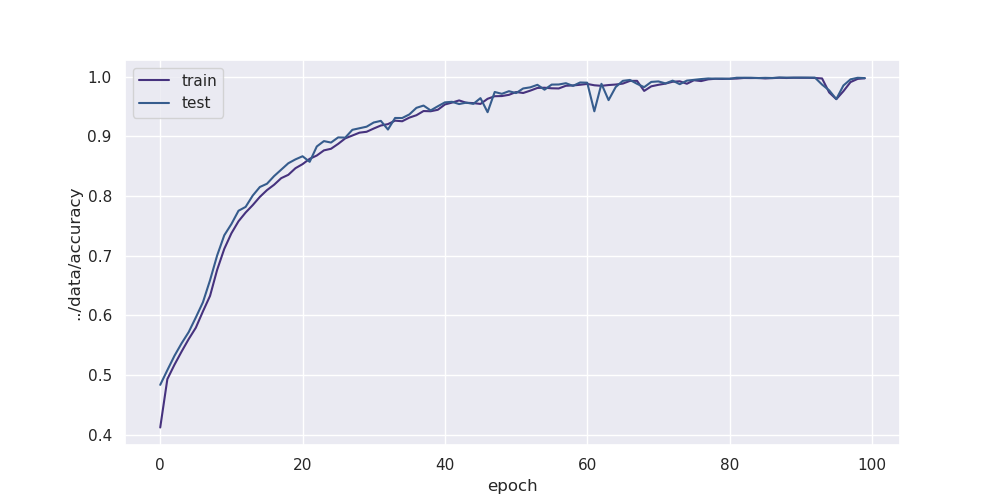

In [10]:
from IPython.display import Image, display_png
display_png(Image("./data/accuracy_q88.png"))

### 89.事前学習済み言語モデルからの転移学習
事前学習済み言語モデル（例えばBERTなど）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．

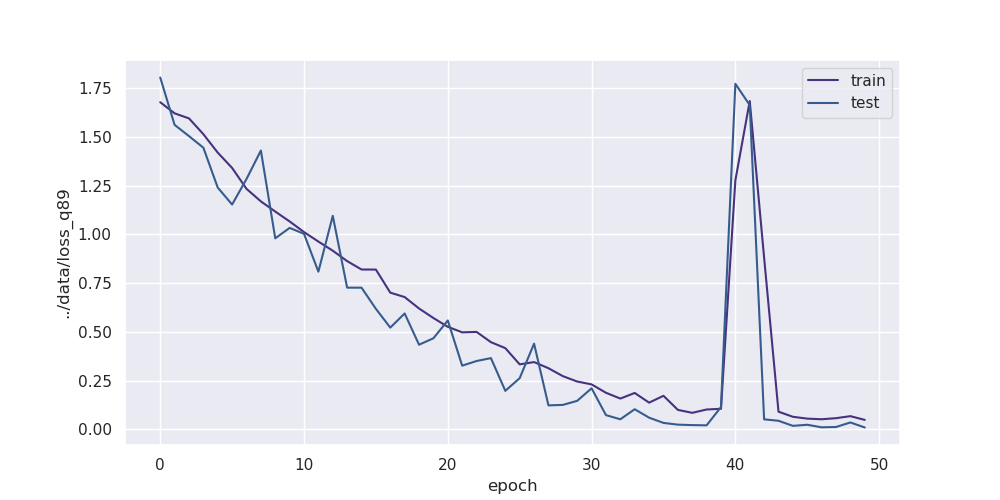

In [4]:
from IPython.display import Image, display_png
display_png(Image("./data/loss_q89.png"))

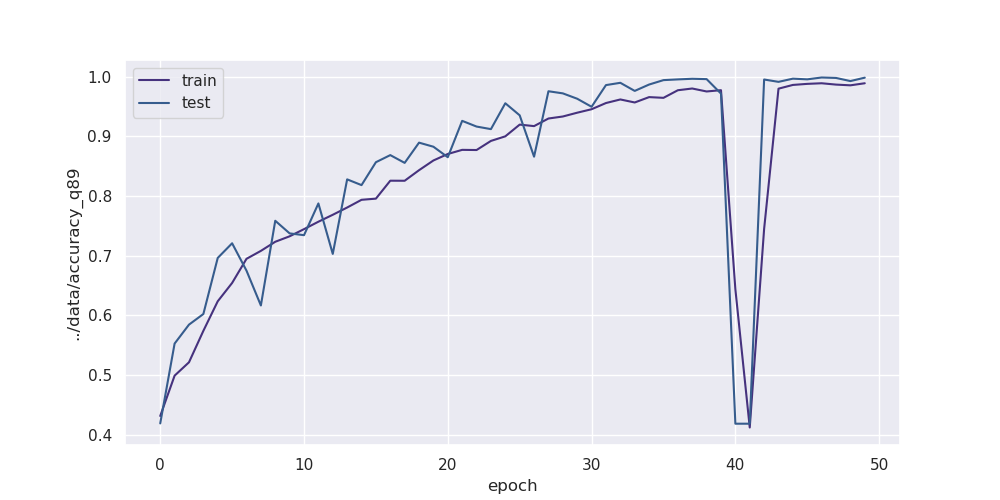

In [3]:
from IPython.display import Image, display_png
display_png(Image("./data/accuracy_q89.png"))